In [1]:
import sys
sys.path.append("/home/risitop/Documents/PHD/vc_project/")
import scripts as vc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import time
import itertools
from sklearn.metrics import homogeneity_score
from pynndescent import NNDescent
from numba import njit

# Plotting

In [2]:
# Plotting parameters

dotsize = 10
qcolor = 'royalblue' # query
qmarker = 's'
rcolor = 'crimson' # reference
rmarker = 'o'
icolor = 'yellow' # integrated
imarker = 'D'
x_label = 'PC1'
y_label = 'PC2'
titlesize = 15
labelsize = 15
legendsize = 10

# Plotting function

def plot_datasets(*datasets,
                   title=None,
                   x_label=None,
                   y_label=None,
                   enable_cbar=False,
                   cbar_title=None,
                   **kwargs):
    for dataset in datasets:
        X = dataset['X']
        color = dataset['c']
        kwargs_to_pass = {k: dataset[k] for k in dataset if k not in ('X', 'c')}
        plt.scatter(*X.T, c=color, **kwargs_to_pass, **kwargs)
    if x_label is not None:
        plt.xlabel(x_label, size=labelsize)
    if y_label is not None:
        plt.ylabel(y_label, size=labelsize)
    if any("label" in dataset for dataset in datasets):
        plt.legend(fontsize=legendsize)
    plt.xticks([])
    plt.yticks([])

    if enable_cbar:
        cbar = plt.colorbar()
        if cbar_title is not None:
            cbar.ax.set_ylabel(cbar_title, fontsize=labelsize)

    if title is not None:
        plt.title(title, fontsize=titlesize)

In [6]:
X, labels = make_blobs(
    n_samples=1000*6,
    n_features=10,
    centers=6
)

In [7]:
n_trees = min(64, 5 + int(round((X.shape[0]) ** 0.5 / 20.0)))
n_iters = max(5, int(round(np.log2(X.shape[0]))))

knn_search_index = NNDescent(
    X,
    n_neighbors=15,
    metric="euclidean",
    n_trees=n_trees,
    n_iters=n_iters,
    max_candidates=60
)

In [13]:
indices, distances = knn_search_index.neighbor_graph

In [14]:
rows, cols, data = [], [], []
for i, ni in enumerate(indices):
    for j in ni:
        rows.append(i)
        cols.append(j)
        data.append(1)

In [19]:
import scipy

scipy.sparse.coo_matrix(
    (data, (rows, cols)), shape=(X.shape[0], X.shape[0])
).tocsr()

<600x600 sparse matrix of type '<class 'numpy.int64'>'
	with 9000 stored elements in Compressed Sparse Row format>

# Generating datasets

In [3]:
n_clusters = [6]
n_samples_per_cluster = [100, 500, 1000, 5000, 10000, 50000]
n_hops = [1, 2, 3]
dimensions = [10]

parameters_combinations = [
    (nc, ns, d, nh) 
    for nc in n_clusters
    for ns in n_samples_per_cluster
    for d in dimensions
    for nh in n_hops
]

results = {}
for nc, ns, d, nh in parameters_combinations:
    
    print(f'n_samples: {ns*nc} / n_clusters: {nc} / dim: {d} / hops: {nh}')
    
    # Initialization
    dct_results = {
        'n_samples': ns*nc,
        'n_clusters': nc,
        'dimension': d,
        'n_hops': nh
    }
    X, labels = make_blobs(
        n_samples=ns*nc,
        n_features=d,
        centers=nc
    )
    X_pca = PCA(n_components=2).fit_transform(X)
    
    # VC
    tic = time.time()
    anchors, mapping = vc.vertex_cover(X, n_neighbors=15, hops=nh)
    dct_results['time_vc'] = time.time() - tic
    dct_results['n_anchors'] = np.sum(anchors).astype(int)
    
    # Clustering
    tic = time.time()
    km = KMeans(n_clusters=nc)
    assignment = km.fit(X).labels_
    dct_results['time_kmeans'] = time.time() - tic
    
    # Clustering+VC
    tic = time.time()
    km = KMeans(n_clusters=nc)
    assignment_vc = km.fit(X[anchors==1]).labels_
    dct_results['time_kmeans_vc'] = time.time() - tic
    
    small_idx = np.array([ # i -> anchor of i mapping
    np.sum(anchors[:mapping[i]]).astype(int)
        for i in range(len(X))
    ])
    
    dct_results['labels'] = labels
    dct_results['assignment'] = assignment
    dct_results['assignment_vc'] = assignment_vc[small_idx]
    
    results[(nc, ns, d, nh)] = dct_results

n_samples: 600 / n_clusters: 6 / dim: 10 / hops: 1
NN...
Symmetrize...
VC...
n_samples: 600 / n_clusters: 6 / dim: 10 / hops: 2
NN...
Symmetrize...
VC...
n_samples: 600 / n_clusters: 6 / dim: 10 / hops: 3
NN...
Symmetrize...
VC...
n_samples: 3000 / n_clusters: 6 / dim: 10 / hops: 1
NN...
Symmetrize...
VC...
n_samples: 3000 / n_clusters: 6 / dim: 10 / hops: 2
NN...
Symmetrize...
VC...
n_samples: 3000 / n_clusters: 6 / dim: 10 / hops: 3
NN...
Symmetrize...
VC...
n_samples: 6000 / n_clusters: 6 / dim: 10 / hops: 1
NN...
Symmetrize...
VC...
n_samples: 6000 / n_clusters: 6 / dim: 10 / hops: 2
NN...
Symmetrize...
VC...
n_samples: 6000 / n_clusters: 6 / dim: 10 / hops: 3
NN...
Symmetrize...
VC...
n_samples: 30000 / n_clusters: 6 / dim: 10 / hops: 1
NN...
Symmetrize...
VC...
n_samples: 30000 / n_clusters: 6 / dim: 10 / hops: 2
NN...
Symmetrize...
VC...
n_samples: 30000 / n_clusters: 6 / dim: 10 / hops: 3
NN...
Symmetrize...
VC...
n_samples: 60000 / n_clusters: 6 / dim: 10 / hops: 1
NN...
Symme

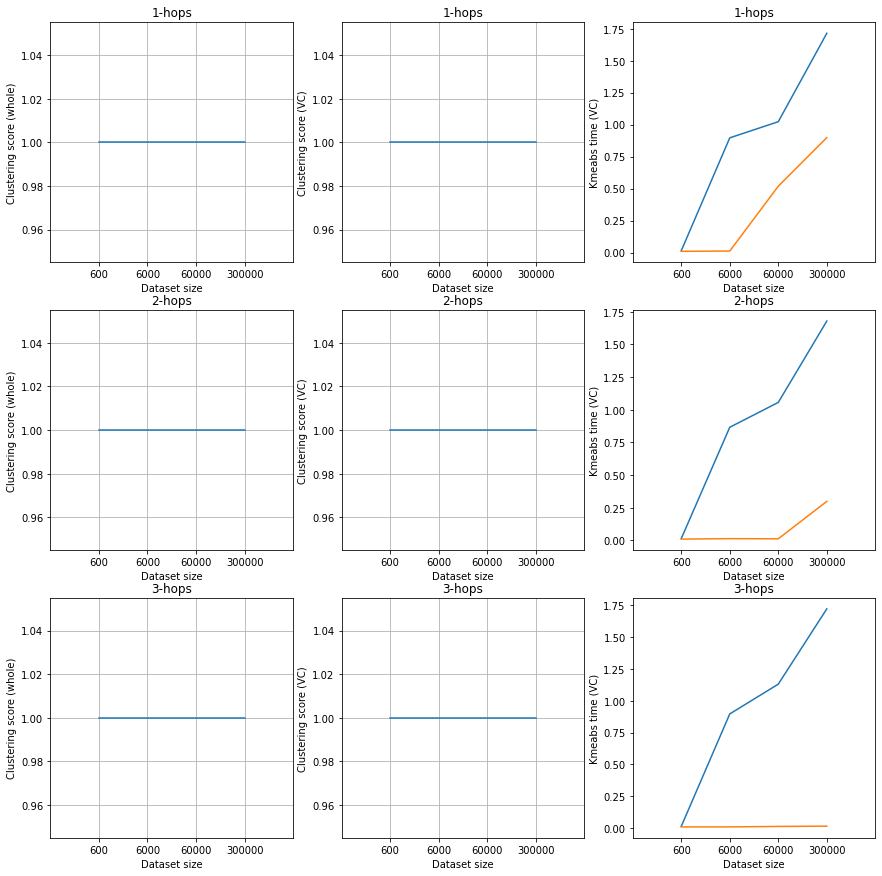

In [4]:
def my_plot(x, y, ylabel="", title=""):
    plt.plot(np.arange(len(x))+1, y)
    plt.xticks(np.arange(len(x))+1, x*6)
    plt.xlabel("Dataset size")
    plt.ylabel(ylabel)
    plt.xlim(0, len(x)+1)
    plt.title(title)
    plt.grid()

sizes = np.array([100, 1000, 10000, 50000])

plt.figure(figsize=(20,15))
for hop in [1,2,3]:
    results_hop = [
        results[(6,i,10,hop)]
        for i in sizes
    ]
    plt.subplot(3,4,4*hop-3)
    my_plot(
        sizes, 
        [
            homogeneity_score(r['labels'], r['assignment'])
            for r in results_hop
        ],
        ylabel="Clustering score (whole)",
        title=f"{hop}-hops"
    )
    
    plt.subplot(3,4,4*hop-2)
    my_plot(
        sizes, 
        [
            homogeneity_score(r['labels'], r['assignment_vc'])
            for r in results_hop
        ],
        ylabel="Clustering score (VC)",
        title=f"{hop}-hops"
    )
    
    plt.subplot(3,4,4*hop-1)
    my_plot(
        sizes, 
        [
            r['time_kmeans']
            for r in results_hop
        ],
        "K-Means time (Whole)",
        title=f"{hop}-hops"
    )
    
    my_plot(
        sizes, 
        [
            r['time_kmeans_vc']
            for r in results_hop
        ],
        "Kmeabs time (VC)",
        title=f"{hop}-hops"
    )